In [1]:
import os
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable


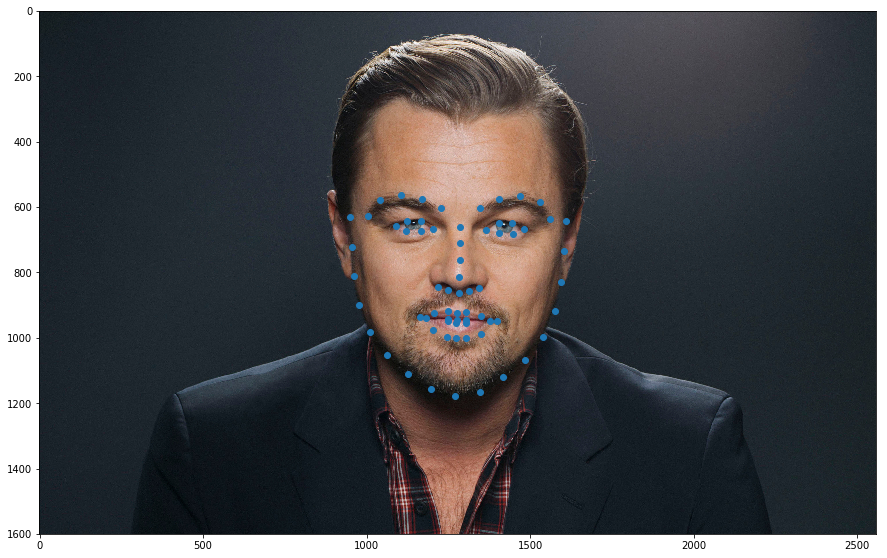

In [2]:
face_image = mpimg.imread('leo.jpg')
# face_image = (doge_image[:, :, :3] * 256).astype(np.uint8)
face_landmarks_gt = detect_landmark(face_image)
H, W = face_image.shape[0], face_image.shape[1]

fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/face_landmarks_gt.png')

In [3]:
# Read Basel Face Model.
N_id = 30
N_exp = 20

bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
# PCA model for facial identity.
mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32).reshape((-1, 3, 199))
pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# PCA model for expression.
mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32).reshape((-1, 3, 100))
pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)

# Pick the largest N_id and N_exp principal components and variances for facial identity and expressions respectively.
E_id = pcaBasis_id[:, :, :N_id]
E_exp = pcaBasis_exp[:, :, :N_exp]
sigma_id = np.sqrt(pcaVariance_id[:N_id])
sigma_exp = np.sqrt(pcaVariance_exp[:N_exp])

# Convert all to PyTorch tensors.
mu_id_torch = torch.Tensor(mu_id)
mu_exp_torch = torch.Tensor(mu_exp)
E_id_torch = torch.Tensor(E_id)
E_exp_torch = torch.Tensor(E_exp)
sigma_id_torch = torch.Tensor(sigma_id)
sigma_exp_torch = torch.Tensor(sigma_exp)

# Read facial landmark indices.
landmarks=[]
with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
    for line in f.readlines():
        landmarks.append(int(line.split('\n')[0]))
landmarks = torch.tensor(landmarks)
# Define groundtruth facial landmarks.
gt_landmark = torch.Tensor(face_landmarks_gt).t()

# Initialize trainable variables.
lambda_alpha = 1
lambda_delta = 1

alpha = Variable(torch.FloatTensor(N_id).uniform_(-1, 1), requires_grad=True)
delta = Variable(torch.FloatTensor(N_exp).uniform_(-1, 1), requires_grad=True)
# omega = Variable(torch.FloatTensor(3).uniform_(-np.pi, np.pi), requires_grad=True)
omega = Variable(torch.zeros(3), requires_grad=True)
t = Variable(torch.Tensor([0, 0, -400]), requires_grad=True)

# Initialize optimizer.
opt = torch.optim.Adam([alpha, delta, omega, t], lr=0.1)

# Define camera projection matrices.
vl,vr,vb,vt = 0, W,0, H
V = torch.Tensor([[(vr-vl)/2.,0,0,(vr+vl)/2.],
              [0,(vt-vb)/2.,0,(vt+vb)/2.],
              [0,0,0.5,0.5],
              [0,0,0,1]])
l,r,b,t_,n,f = 0, 150, 0, 200, 1, 100
P = torch.Tensor([[(2*n)/(r-l),0,(r+l)/(r-l),0],
              [0,(2*n)/(t_-b),(t_+b)/(t_-b),0],
              [0,0,-(f+n)/(f-n),-(2*f*n)/(f-b)],
              [0,0,-1,0]])

# G_landmark = torch.ones((4,len(landmarks)))

for epoch in np.arange(500):
    opt.zero_grad()    
    G = mu_id_torch + E_id_torch @ (alpha * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta * sigma_exp_torch)    
    G_landmark_tmp = torch.transpose(torch.index_select(G, 0, landmarks), 0, 1)
    G_landmark = torch.cat((G_landmark_tmp, torch.ones(1, len(landmarks))), 0)
    
    Rx, Ry, Rz = torch.zeros(3, 3), torch.zeros(3, 3), torch.zeros(3, 3)
    Rx[0, 0] = 1.
    Rx[1, 1] = torch.cos(omega[0])
    Rx[1, 2] = -torch.sin(omega[0])
    Rx[2, 1] = torch.sin(omega[0])
    Rx[2, 2] = torch.cos(omega[0])
#     Rx = torch.tensor([[1., 0., 0.], 
#                        [0, torch.cos(omega[0]), -torch.sin(omega[0])], 
#                        [0, torch.sin(omega[0]), torch.cos(omega[0])]
#                       ], requires_grad=True)
    Ry[0, 0] = torch.cos(omega[1])
    Ry[0, 2] = torch.sin(omega[1])
    Ry[1, 1] = 1.
    Ry[2, 0] = -torch.sin(omega[1])
    Ry[2, 2] = torch.cos(omega[1])
#     Ry = torch.tensor([[torch.cos(omega[1]), 0, torch.sin(omega[1])],
#                        [0., 1., 0.],
#                        [-torch.sin(omega[1]), 0, torch.cos(omega[1])]
#                       ], requires_grad=True)
    
    Rz[0, 0] = torch.cos(omega[2])
    Rz[0, 1] = -torch.sin(omega[2])
    Rz[1, 0] = torch.sin(omega[2])
    Rz[1, 1] = torch.cos(omega[2])
    Rz[2, 2] = 1.
#     Rz = torch.tensor([[torch.cos(omega[2]), -torch.sin(omega[2]), 0],
#                        [torch.sin(omega[2]), torch.cos(omega[2]), 0],
#                        [0., 0., 1.]
#                       ], requires_grad=True)
    
    R = Rx @ Ry @ Rz
    T = torch.cat((torch.cat((R, t.view(-1, 1)), dim=1), torch.tensor([0., 0., 0., 1.]).view(1, -1)), dim=0)   

    out = V @ P @ T @ G_landmark
    pred_landmark = torch.empty_like(gt_landmark)
    # Divide by the homogeneous dimension?
#     pred_landmark[0, :] = out[0, :] / out[3, :]
    pred_landmark[0, :] = out[0, :]
#     pred_landmark[1, :] = out[1, :] / out[3, :]
    pred_landmark[1, :] = out[1, :]

    L_landmark = (pred_landmark - gt_landmark).pow(2).sum(dim=0).sqrt().sum()
    L_regularizer = lambda_alpha * alpha.pow(2).sum() + lambda_delta * delta.pow(2).sum()
    L_fit = L_landmark + L_regularizer
    L_fit.backward(retain_graph=True)
    opt.step()    
    print('Epoch: {}, L_landmark: {:.3f}, L_regularizer: {:.3f}'.format(epoch, L_landmark, L_regularizer))



Epoch: 0, L_landmark: 109681.078, L_regularizer: 19.543
Epoch: 1, L_landmark: 97859.258, L_regularizer: 21.120
Epoch: 2, L_landmark: 86174.789, L_regularizer: 23.927
Epoch: 3, L_landmark: 74930.727, L_regularizer: 27.579
Epoch: 4, L_landmark: 64652.461, L_regularizer: 31.799
Epoch: 5, L_landmark: 56111.488, L_regularizer: 36.633
Epoch: 6, L_landmark: 49635.980, L_regularizer: 41.902
Epoch: 7, L_landmark: 45187.223, L_regularizer: 47.431
Epoch: 8, L_landmark: 42350.852, L_regularizer: 52.977
Epoch: 9, L_landmark: 41140.914, L_regularizer: 58.194
Epoch: 10, L_landmark: 40961.164, L_regularizer: 62.713
Epoch: 11, L_landmark: 40980.211, L_regularizer: 66.286
Epoch: 12, L_landmark: 40826.852, L_regularizer: 68.865
Epoch: 13, L_landmark: 40308.309, L_regularizer: 70.536
Epoch: 14, L_landmark: 39361.895, L_regularizer: 71.446
Epoch: 15, L_landmark: 37989.945, L_regularizer: 71.772
Epoch: 16, L_landmark: 36246.148, L_regularizer: 71.698
Epoch: 17, L_landmark: 34242.762, L_regularizer: 71.412
E

Epoch: 143, L_landmark: 8774.232, L_regularizer: 1736.945
Epoch: 144, L_landmark: 8703.466, L_regularizer: 1750.353
Epoch: 145, L_landmark: 8634.238, L_regularizer: 1763.723
Epoch: 146, L_landmark: 8564.803, L_regularizer: 1776.934
Epoch: 147, L_landmark: 8495.502, L_regularizer: 1790.049
Epoch: 148, L_landmark: 8429.128, L_regularizer: 1803.075
Epoch: 149, L_landmark: 8363.752, L_regularizer: 1815.945
Epoch: 150, L_landmark: 8309.299, L_regularizer: 1828.784
Epoch: 151, L_landmark: 8230.568, L_regularizer: 1841.505
Epoch: 152, L_landmark: 8182.398, L_regularizer: 1854.081
Epoch: 153, L_landmark: 8113.038, L_regularizer: 1866.473
Epoch: 154, L_landmark: 8040.706, L_regularizer: 1878.793
Epoch: 155, L_landmark: 7998.110, L_regularizer: 1891.056
Epoch: 156, L_landmark: 7912.533, L_regularizer: 1903.113
Epoch: 157, L_landmark: 7862.505, L_regularizer: 1915.114
Epoch: 158, L_landmark: 7792.305, L_regularizer: 1927.057
Epoch: 159, L_landmark: 7731.220, L_regularizer: 1938.828
Epoch: 160, L_

Epoch: 288, L_landmark: 3887.632, L_regularizer: 2314.907
Epoch: 289, L_landmark: 3807.126, L_regularizer: 2312.762
Epoch: 290, L_landmark: 3761.071, L_regularizer: 2310.594
Epoch: 291, L_landmark: 3796.726, L_regularizer: 2308.101
Epoch: 292, L_landmark: 3752.504, L_regularizer: 2305.473
Epoch: 293, L_landmark: 3713.993, L_regularizer: 2303.102
Epoch: 294, L_landmark: 3717.358, L_regularizer: 2300.778
Epoch: 295, L_landmark: 3711.039, L_regularizer: 2298.511
Epoch: 296, L_landmark: 3692.937, L_regularizer: 2296.482
Epoch: 297, L_landmark: 3655.425, L_regularizer: 2294.591
Epoch: 298, L_landmark: 3669.973, L_regularizer: 2292.645
Epoch: 299, L_landmark: 3715.758, L_regularizer: 2290.604
Epoch: 300, L_landmark: 3654.554, L_regularizer: 2288.642
Epoch: 301, L_landmark: 3602.303, L_regularizer: 2287.130
Epoch: 302, L_landmark: 3641.765, L_regularizer: 2285.365
Epoch: 303, L_landmark: 3615.351, L_regularizer: 2283.371
Epoch: 304, L_landmark: 3612.608, L_regularizer: 2281.447
Epoch: 305, L_

Epoch: 434, L_landmark: 2437.907, L_regularizer: 1908.134
Epoch: 435, L_landmark: 2458.647, L_regularizer: 1906.391
Epoch: 436, L_landmark: 2526.594, L_regularizer: 1904.129
Epoch: 437, L_landmark: 2397.552, L_regularizer: 1901.982
Epoch: 438, L_landmark: 2411.061, L_regularizer: 1899.333
Epoch: 439, L_landmark: 2416.860, L_regularizer: 1896.750
Epoch: 440, L_landmark: 2464.406, L_regularizer: 1894.098
Epoch: 441, L_landmark: 2418.190, L_regularizer: 1890.650
Epoch: 442, L_landmark: 2375.235, L_regularizer: 1887.102
Epoch: 443, L_landmark: 2414.809, L_regularizer: 1883.940
Epoch: 444, L_landmark: 2469.883, L_regularizer: 1880.238
Epoch: 445, L_landmark: 2368.108, L_regularizer: 1877.110
Epoch: 446, L_landmark: 2333.052, L_regularizer: 1873.679
Epoch: 447, L_landmark: 2358.093, L_regularizer: 1870.981
Epoch: 448, L_landmark: 2429.984, L_regularizer: 1868.767
Epoch: 449, L_landmark: 2425.546, L_regularizer: 1866.031
Epoch: 450, L_landmark: 2335.605, L_regularizer: 1863.518
Epoch: 451, L_

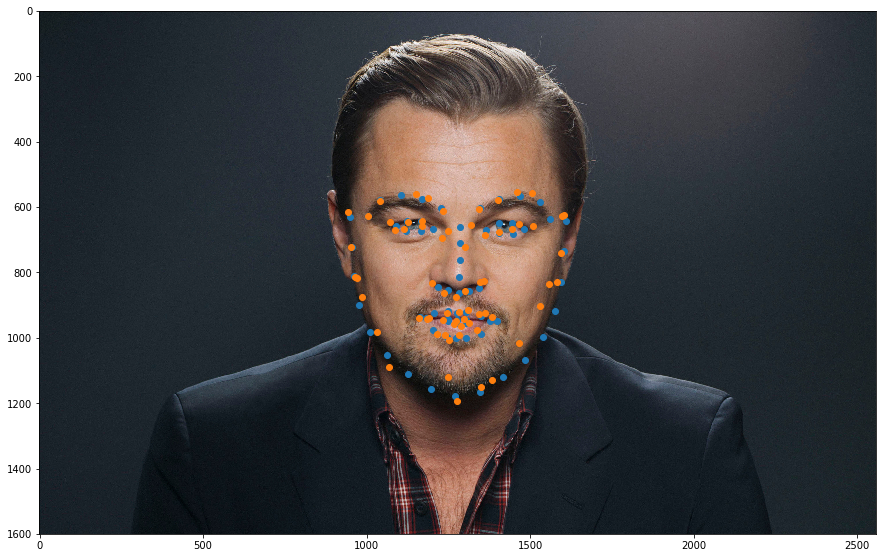

In [4]:
fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.scatter(pred_landmark.detach().numpy()[0, :], pred_landmark.detach().numpy()[1, :])
plt.axes().set_aspect('equal')
plt.show()

In [5]:
from torchviz import make_dot
graph = make_dot(L_landmark)
graph.view()

'Digraph.gv.pdf'

In [6]:
# test_a = t / omega
# graph = make_dot(test_a)
# graph.view()

'Digraph.gv.pdf'